In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd drive/My Drive/Colab Notebooks/TOPICS IN APPLIED STATISTICS1/11

/content/drive/My Drive/Colab Notebooks/TOPICS IN APPLIED STATISTICS1/11


In [0]:
import tensorflow.keras 
from tensorflow.keras import layers
from tensorflow.keras import backend as k
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import numpy as np

In [0]:
img_shape=(28,28,1)
batch_size=16
latent_dim=2  # normal가정이 2변량정규분포.

input_img=layers.Input(shape=img_shape)
x=layers.Conv2D(32,3,padding='same', strides=2, activation='relu')(input_img)
x=layers.Conv2D(64,3, padding='same', strides=2, activation='relu')(x)
shape=k.int_shape(x)
x=layers.Flatten()(x)
x=layers.Dense(32, activation='relu')(x)
z_mean=layers.Dense(latent_dim)(x)
z_log_var=layers.Dense(latent_dim)(x) # log variance 임. loss function에서 log를 썼을때 수렴이 더빠름.
# log를 안써도 됨.

In [0]:
# inference loss를 정의하려고 그럼.

def sampling(args):
    z_mean,z_log_var=args
    batch=k.shape(z_mean)[0] # z_mean은 (none,2), none을 제외한다면 2차원 열 벡터임.  k.shape 하면, tensor그릇을 생성. k.int_shape하면 숫자를 생성.
    dim=k.int_shape(z_mean)[1]
    epsilon=k.random_normal(shape=(batch,dim)) # normal(0,1) // z의 노드를 iid로 가정하기 때문에 이게 가능. 개별로봄. 이걸 가정하자는게 결론이었음.
    return z_mean+k.exp(0.5*z_log_var)*epsilon  # 공식 정의. # 0.5*z_log_var = log (sigma) 임.


z=layers.Lambda(sampling,output_shape=(latent_dim,))([z_mean,z_log_var])  # 함수에 해당하는 인자를 인자를 input으로 받음. 그리고 그 input은 layer였음. 이렇게 되면, z라는 노드는 mu1, sigma1 정규에서 만들어진 값. 
# layer 로 정의해주려면 lambda함수를 사용하면 됨.
# built - in 이 아니기 때문에, 이렇게 만들어놓음.
# output_shape=(latent_dim,) 안써도 됨.


# *************** 아래는 매우 중요 ****************
# 정리하자면,
# encoder는 최종적인 잠재변수 z가 N(0,1) 이 되도록 parameter(beta)가 학습됨. 즉, mu=0,sigma=1 의 노드를 갖도록 앞의 encoder beta들이 학습됨.
# 그리고 이와 동시에, decoder쪽에서도 loss를 줄이기 위해 대응되면서 parameter가 학습됨. (output이 잘 나오도록.)
# 이게, 어떤 데이터가 들어오더라도 이렇게 이루어지기 때문에, 모두가 동시에 살아 움직이는거임.

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 14, 14, 32)   320         input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 7, 7, 64)     18496       conv2d_14[0][0]                  
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 3136)         0           conv2d_15[0][0]                  
___________________________________________________________________________________________

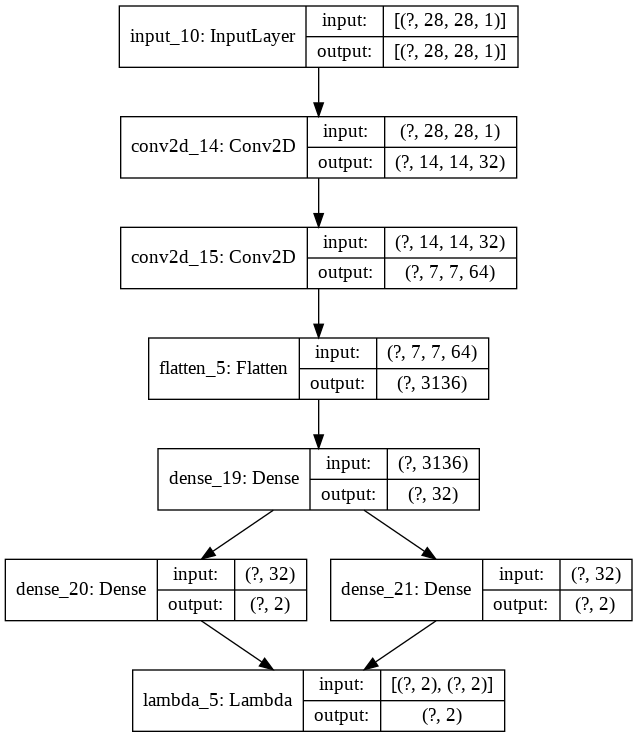

In [54]:
# endoer term

encoder=Model(input_img,[z_mean,z_log_var,z] ) # 이렇게 3개를 output으로 꺼낼수 있음. 그러면 encoder를 통과할 시, output이 3개로 나옴. 물론 그림에서는 의미없음.
encoder.summary()
plot_model(encoder,show_shapes=True)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_22 (Dense)             (None, 3136)              9408      
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
______________________________________________________

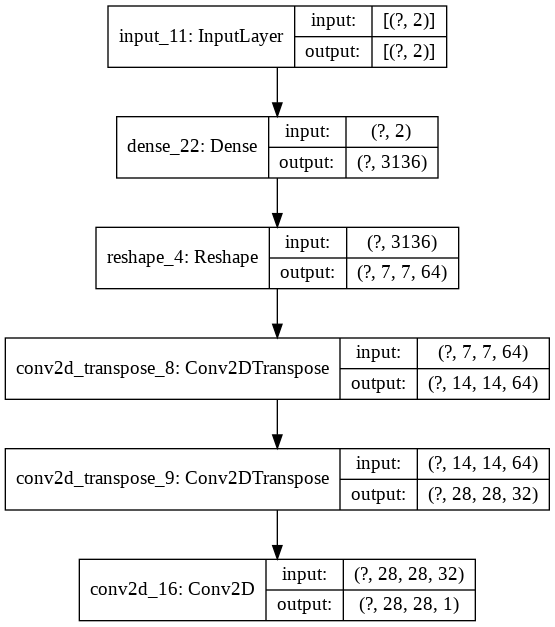

In [55]:
# decoder term

latent_input=layers.Input(shape=(latent_dim,))
x=layers.Dense(np.prod(shape[1:]), activation='relu')(latent_input) # np.prod 곱하기
x=layers.Reshape(shape[1:])(x) # reshape을 진행.
x=layers.Conv2DTranspose(64,3,padding='same',strides=2,activation='relu')(x)
x=layers.Conv2DTranspose(32,3,padding='same',strides=2,activation='relu')(x)
output=layers.Conv2D(1,3, padding='same',activation='sigmoid')(x)
decoder=Model(latent_input,output)
decoder.summary()
plot_model(decoder, show_shapes=True)

In [56]:
f_output=decoder(encoder(input_img)[2])  # 나는 z에 해당하는 부분만 볼것이기 때문에 이렇게 씀.
vae=Model(input_img, f_output)
vae.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_14 (Model)             [(None, 2), (None, 2), (N 119332    
_________________________________________________________________
model_15 (Model)             (None, 28, 28, 1)         65089     
Total params: 184,421
Trainable params: 184,421
Non-trainable params: 0
_________________________________________________________________


In [57]:
# loss function이 built-in이 아니기 떄문에, 정의해야함.
# customized loss를 함.
input_img1=k.flatten(input_img) #none 으로 나오지만, 이게 1차원 tensor인거임. 1차원 칸에 해당하는 값이 (28x28의 길이만큼) 들어가있음.
f_output1=k.flatten(f_output)
print(input_img1, f_output1)

reconstruction_loss=tensorflow.keras.losses.mse(input_img1, f_output1) # 모든 pixel에 대해 mse를 구함.
reconstruction_loss*=input_img.shape[1]*input_img.shape[1] # 28*28를 곱하는 이유는, 28*28에 대한 평균을 구했기 때문에 그럼. 우리는 loss(summation으로 이루어짐.)를 구하기 위해선, 28*28을 곱해줌.

inference_loss=1 + z_log_var-k.square(z_mean)-k.exp(z_log_var) # 추론손실 이해 
inference_loss=k.sum(inference_loss, axis=-1)*-0.5

vae_loss=k.mean(reconstruction_loss+inference_loss)

vae.add_loss(vae_loss)
# loss로 정의하려면 add_loss를 정의하면 끝.

vae.compile(optimizer='rmsprop')

Tensor("Reshape_9:0", shape=(None,), dtype=float32) Tensor("Reshape_10:0", shape=(None,), dtype=float32)


In [58]:
from tensorflow.keras.datasets import mnist

(x_train,_),(x_test,y_test)=mnist.load_data()
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


vae.fit(x_train, epochs=10, shuffle=True, batch_size=batch_size, validation_data=(x_test,None)) # none 을 쓰거나, 1개만 입력해도 됨.

Epoch 1/10
3750/3750 [==============================] - 32s 8ms/step - loss: 43.5616 - val_loss: 40.3789
Epoch 2/10
3750/3750 [==============================] - 31s 8ms/step - loss: 39.6573 - val_loss: 38.6506
Epoch 3/10
3750/3750 [==============================] - 31s 8ms/step - loss: 38.6473 - val_loss: 38.1189
Epoch 4/10
3750/3750 [==============================] - 31s 8ms/step - loss: 38.1253 - val_loss: 38.0094
Epoch 5/10
3750/3750 [==============================] - 31s 8ms/step - loss: 37.8359 - val_loss: 38.0315
Epoch 6/10
3750/3750 [==============================] - 31s 8ms/step - loss: 37.5944 - val_loss: 37.5953
Epoch 7/10
3750/3750 [==============================] - 31s 8ms/step - loss: 37.4476 - val_loss: 37.5942
Epoch 8/10
3750/3750 [==============================] - 31s 8ms/step - loss: 37.3260 - val_loss: 37.5601
Epoch 9/10
3750/3750 [==============================] - 31s 8ms/step - loss: 37.2305 - val_loss: 37.8076
Epoch 10/10
3750/3750 [==============================] 

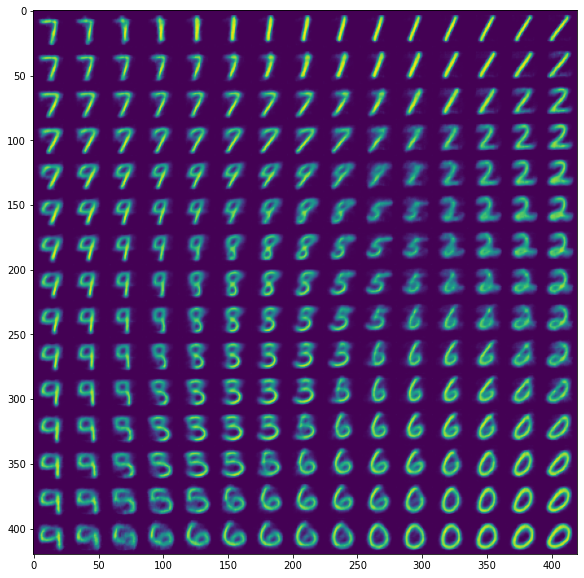

In [59]:
# 이 아래는 재생시켜서 확인하는 코드.
# decoder 에 z sample 그대로 넣으면됨.
# 이미지가 어떻게 변해가는지를 확인할 수 있음.


import matplotlib.pyplot as plt
from scipy.stats import norm
n=15
image_size=28
figure=np.zeros((image_size*n,image_size*n)) # 15x15개의 숫자를 출력할 예정. -> 15*28 = 420 이며, output그림의 한 변의길이.
z_x=norm.ppf(np.linspace(0.05,0.95,n)) # standard normal에서 그냥꺼냄. / z는 그 의미답게 히든노드의 의미임.
z_y=norm.ppf(np.linspace(0.05,0.95,n))

for i,y in enumerate(z_y): # y축의 분위수값
    for j, x in enumerate(z_x): # x축의 분위수값
        z_sample=np.array([[x,y]]) # 결과 class에 대한 분포에 대해, x축: 하위 5%, y축: 하위 5%
        z_sample=np.tile(z_sample, batch_size).reshape(batch_size,2) 
        # np.tile(A,(2,3,4)) 는 , A를 (2,3,4) 차원만큼 복사해라 라는 의미. 즉, A=(a1,a2,a3)라 할 때, output= (2a1,3a2,4a3) 의 차원을 지님. 
        # 여기서는, np.tile(z_sample,16) 이므로, z_sample을 -1축으로 16개 복사함. 이를 reshape하므로, z_sample의 최종 shape은 당연히 (16,2)

        x_decoded=decoder.predict(z_sample) # 16개의 예제에 대해, decoder predict를 진행. 이때 encoder는 사용을 안함.
        digit=x_decoded[0].reshape(image_size, image_size) # 1개의 sample에 대해서, 진행.
        figure[i*image_size:(i+1)*image_size, j*image_size:(j+1)*image_size]=digit # 하나씩 하나씩 할당. 왼쪽 위 대각선부터 할당. 

plt.figure(figsize=(10,10)) # 즉 , 이게 숫자분포. (decoder 분포)
plt.imshow(figure)
plt.show()




In [0]:
# 1. VAE에서 normal latent dimension을 증가시켜 변화를 점검하여 해설할 것.

In [0]:
img_shape=(28,28,1)
batch_size=16
latent_dim=5  # normal가정이 2변량정규분포.

input_img=layers.Input(shape=img_shape)
x=layers.Conv2D(32,3,padding='same', strides=2, activation='relu')(input_img)
x=layers.Conv2D(64,3, padding='same', strides=2, activation='relu')(x)
shape=k.int_shape(x)
x=layers.Flatten()(x)
x=layers.Dense(32, activation='relu')(x)
z_mean=layers.Dense(latent_dim)(x)
z_log_var=layers.Dense(latent_dim)(x) # log variance 임. loss function에서 log를 썼을때 수렴이 더빠름.
# log를 안써도 됨.

In [0]:
# inference loss를 정의하려고 그럼.

def sampling(args):
    z_mean,z_log_var=args
    batch=k.shape(z_mean)[0] # z_mean은 (none,2), none을 제외한다면 2차원 열 벡터임.  k.shape 하면, tensor그릇을 생성. k.int_shape하면 숫자를 생성.
    dim=k.int_shape(z_mean)[1]
    epsilon=k.random_normal(shape=(batch,dim)) # normal(0,1) // z의 노드를 iid로 가정하기 때문에 이게 가능. 개별로봄. 이걸 가정하자는게 결론이었음.
    return z_mean+k.exp(0.5*z_log_var)*epsilon  # 공식 정의. # 0.5*z_log_var = log (sigma) 임.


z=layers.Lambda(sampling,output_shape=(latent_dim,))([z_mean,z_log_var])  # 함수에 해당하는 인자를 인자를 input으로 받음. 그리고 그 input은 layer였음. 이렇게 되면, z라는 노드는 mu1, sigma1 정규에서 만들어진 값. 
# layer 로 정의해주려면 lambda함수를 사용하면 됨.
# built - in 이 아니기 때문에, 이렇게 만들어놓음.
# output_shape=(latent_dim,) 안써도 됨.


# *************** 아래는 매우 중요 ****************
# 정리하자면,
# encoder는 최종적인 잠재변수 z가 N(0,1) 이 되도록 parameter(beta)가 학습됨. 즉, mu=0,sigma=1 의 노드를 갖도록 앞의 encoder beta들이 학습됨.
# 그리고 이와 동시에, decoder쪽에서도 loss를 줄이기 위해 대응되면서 parameter가 학습됨. (output이 잘 나오도록.)
# 이게, 어떤 데이터가 들어오더라도 이렇게 이루어지기 때문에, 모두가 동시에 살아 움직이는거임.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_3[0][0]                   
____________________________________________________________________________________________

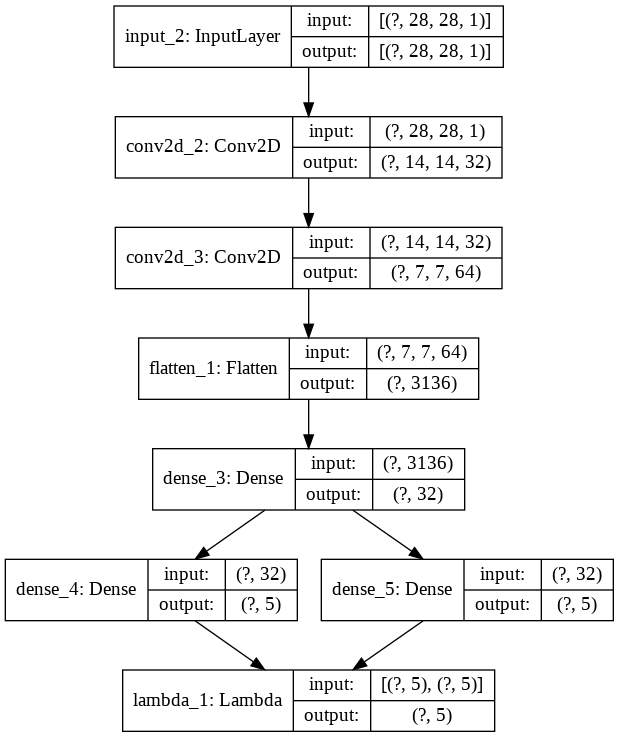

In [9]:
# endoer term

encoder=Model(input_img,[z_mean,z_log_var,z] ) # 이렇게 3개를 output으로 꺼낼수 있음. 그러면 encoder를 통과할 시, output이 3개로 나옴. 물론 그림에서는 의미없음.
encoder.summary()
plot_model(encoder,show_shapes=True)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3136)              18816     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 74,497
Trainable params: 74,497
Non-trainable params: 0
_______________________________________________________

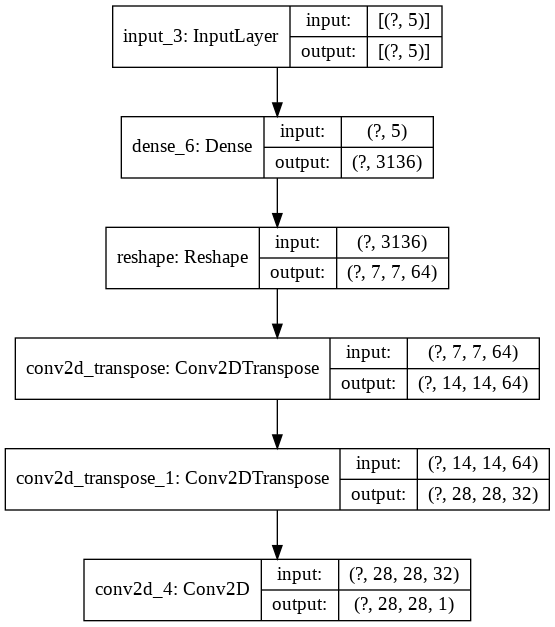

In [10]:
# decoder term

latent_input=layers.Input(shape=(latent_dim,))
x=layers.Dense(np.prod(shape[1:]), activation='relu')(latent_input) # np.prod 곱하기
x=layers.Reshape(shape[1:])(x) # reshape을 진행.
x=layers.Conv2DTranspose(64,3,padding='same',strides=2,activation='relu')(x)
x=layers.Conv2DTranspose(32,3,padding='same',strides=2,activation='relu')(x)
output=layers.Conv2D(1,3, padding='same',activation='sigmoid')(x)
decoder=Model(latent_input,output)
decoder.summary()
plot_model(decoder, show_shapes=True)

In [11]:
f_output=decoder(encoder(input_img)[2])  # 나는 z에 해당하는 부분만 볼것이기 때문에 이렇게 씀.
vae=Model(input_img, f_output)
vae.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_1 (Model)              [(None, 5), (None, 5), (N 119530    
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         74497     
Total params: 194,027
Trainable params: 194,027
Non-trainable params: 0
_________________________________________________________________


In [12]:
# loss function이 built-in이 아니기 떄문에, 정의해야함.
# customized loss를 함.
input_img1=k.flatten(input_img) #none 으로 나오지만, 이게 1차원 tensor인거임. 1차원 칸에 해당하는 값이 (28x28의 길이만큼) 들어가있음.
f_output1=k.flatten(f_output)
print(input_img1, f_output1)

reconstruction_loss=tensorflow.keras.losses.mse(input_img1, f_output1) # 모든 pixel에 대해 mse를 구함.
reconstruction_loss*=input_img.shape[1]*input_img.shape[1] # 28*28를 곱하는 이유는, 28*28에 대한 평균을 구했기 때문에 그럼. 우리는 loss(summation으로 이루어짐.)를 구하기 위해선, 28*28을 곱해줌.

inference_loss=1 + z_log_var-k.square(z_mean)-k.exp(z_log_var) # 추론손실 이해 
inference_loss=k.sum(inference_loss, axis=-1)*-0.5

vae_loss=k.mean(reconstruction_loss+inference_loss)

vae.add_loss(vae_loss)
# loss로 정의하려면 add_loss를 정의하면 끝.

vae.compile(optimizer='rmsprop')

Tensor("Reshape_1:0", shape=(None,), dtype=float32) Tensor("Reshape_2:0", shape=(None,), dtype=float32)


In [13]:
from tensorflow.keras.datasets import mnist

(x_train,_),(x_test,y_test)=mnist.load_data()
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


vae.fit(x_train, epochs=10, shuffle=True, batch_size=batch_size, validation_data=(x_test,None)) # none 을 쓰거나, 1개만 입력해도 됨.

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/10
3750/3750 [==============================] - 31s 8ms/step - loss: 39.7001 - val_loss: 34.4980
Epoch 2/10
3750/3750 [==============================] - 29s 8ms/step - loss: 33.3910 - val_loss: 32.4663
Epoch 3/10
3750/3750 [==============================] - 29s 8ms/step - loss: 32.3845 - val_loss: 32.2945
Epoch 4/10
3750/3750 [==============================] - 29s 8ms/step - loss: 31.8647 - val_loss: 31.3783
Epoch 5/10
3750/3750 [==============================] - 29s 8ms/step - loss: 31.5468 - val_loss: 31.8840
Epoch 6/10
3750/3750 [==============================] - 29s 8ms/step - loss: 31.2929 - val_loss: 31.1689
Epoch 7/10
3750/3750 [==============================] - 30s 8ms/step - loss: 31.1091 - val_loss: 31.2406
Epoch 8/10
3750/3750 [==============================] - 29s 8ms/step - loss: 30.9492 - val_loss: 30.7541
Epoch 9/10
3750/3750 [==============================] - 29s 8ms/step - loss: 30.8474 - val_loss

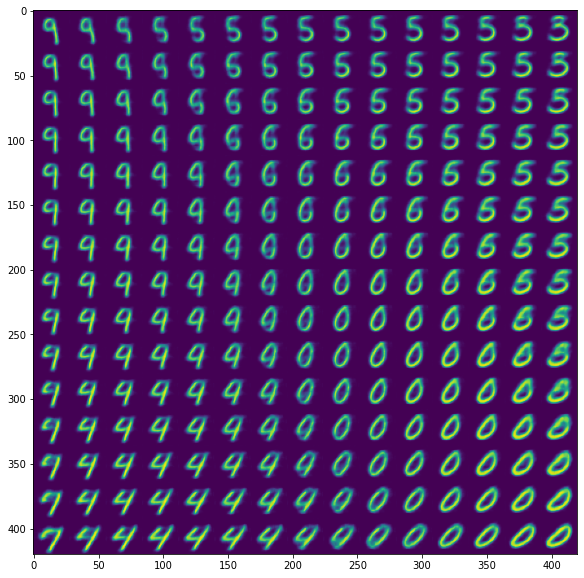

In [20]:
# 이 아래는 재생시켜서 확인하는 코드.
# decoder 에 z sample 그대로 넣으면됨.
# 이미지가 어떻게 변해가는지를 확인할 수 있음.


import matplotlib.pyplot as plt
from scipy.stats import norm
n=15
image_size=28
figure=np.zeros((image_size*n,image_size*n)) # 15x15개의 숫자를 출력할 예정. -> 15*28 = 420 이며, output그림의 한 변의길이.
z_x=norm.ppf(np.linspace(0.05,0.95,n)) # standard normal에서 그냥꺼냄. / z는 그 의미답게 히든노드의 의미임.
z_y=norm.ppf(np.linspace(0.05,0.95,n)) 

for i,y in enumerate(z_y): # y축의 분위수값
    for j, x in enumerate(z_x): # x축의 분위수값
        z_sample=np.array([[x,y,0.5,0.5,0.5]]) # 결과 class에 대한 분포에 대해, x축: 하위 5%, y축: 하위 5%
        z_sample=np.tile(z_sample, batch_size).reshape(batch_size,latent_dim) 
        # np.tile(A,(2,3,4)) 는 , A를 (2,3,4) 차원만큼 복사해라 라는 의미. 즉, A=(a1,a2,a3)라 할 때, output= (2a1,3a2,4a3) 의 차원을 지님. 
        # 여기서는, np.tile(z_sample,16) 이므로, z_sample을 -1축으로 16개 복사함. 이를 reshape하므로, z_sample의 최종 shape은 당연히 (16,2)

        x_decoded=decoder.predict(z_sample) # 16개의 예제에 대해, decoder predict를 진행. 이때 encoder는 사용을 안함.
        digit=x_decoded[0].reshape(image_size, image_size) # 1개의 sample에 대해서, 진행.
        figure[i*image_size:(i+1)*image_size, j*image_size:(j+1)*image_size]=digit # 하나씩 하나씩 할당. 왼쪽 위 대각선부터 할당. 

plt.figure(figsize=(10,10)) # 즉 , 이게 숫자분포. (decoder 분포)
plt.imshow(figure)
plt.show()




In [0]:
# 2. VAE 프로그램에서 channel수를 32-->64-->128로 증가시켜 비교할 것.

In [0]:
img_shape=(28,28,1)
batch_size=16
latent_dim=2  # normal가정이 2변량정규분포.

input_img=layers.Input(shape=img_shape)
x=layers.Conv2D(32,3,padding='same', strides=2, activation='relu')(input_img)
x=layers.Conv2D(64,3, padding='same', strides=2, activation='relu')(x)
shape=k.int_shape(x)
x=layers.Flatten()(x)
x=layers.Dense(64, activation='relu')(x)
z_mean=layers.Dense(latent_dim)(x)
z_log_var=layers.Dense(latent_dim)(x) # log variance 임. loss function에서 log를 썼을때 수렴이 더빠름.
# log를 안써도 됨.

In [0]:
# inference loss를 정의하려고 그럼.

def sampling(args):
    z_mean,z_log_var=args
    batch=k.shape(z_mean)[0] # z_mean은 (none,2), none을 제외한다면 2차원 열 벡터임.  k.shape 하면, tensor그릇을 생성. k.int_shape하면 숫자를 생성.
    dim=k.int_shape(z_mean)[1]
    epsilon=k.random_normal(shape=(batch,dim)) # normal(0,1) // z의 노드를 iid로 가정하기 때문에 이게 가능. 개별로봄. 이걸 가정하자는게 결론이었음.
    return z_mean+k.exp(0.5*z_log_var)*epsilon  # 공식 정의. # 0.5*z_log_var = log (sigma) 임.


z=layers.Lambda(sampling,output_shape=(latent_dim,))([z_mean,z_log_var])  # 함수에 해당하는 인자를 인자를 input으로 받음. 그리고 그 input은 layer였음. 이렇게 되면, z라는 노드는 mu1, sigma1 정규에서 만들어진 값. 
# layer 로 정의해주려면 lambda함수를 사용하면 됨.
# built - in 이 아니기 때문에, 이렇게 만들어놓음.
# output_shape=(latent_dim,) 안써도 됨.


# *************** 아래는 매우 중요 ****************
# 정리하자면,
# encoder는 최종적인 잠재변수 z가 N(0,1) 이 되도록 parameter(beta)가 학습됨. 즉, mu=0,sigma=1 의 노드를 갖도록 앞의 encoder beta들이 학습됨.
# 그리고 이와 동시에, decoder쪽에서도 loss를 줄이기 위해 대응되면서 parameter가 학습됨. (output이 잘 나오도록.)
# 이게, 어떤 데이터가 들어오더라도 이렇게 이루어지기 때문에, 모두가 동시에 살아 움직이는거임.

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 14, 14, 32)   320         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_8[0][0]                   
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 3136)         0           conv2d_9[0][0]                   
____________________________________________________________________________________________

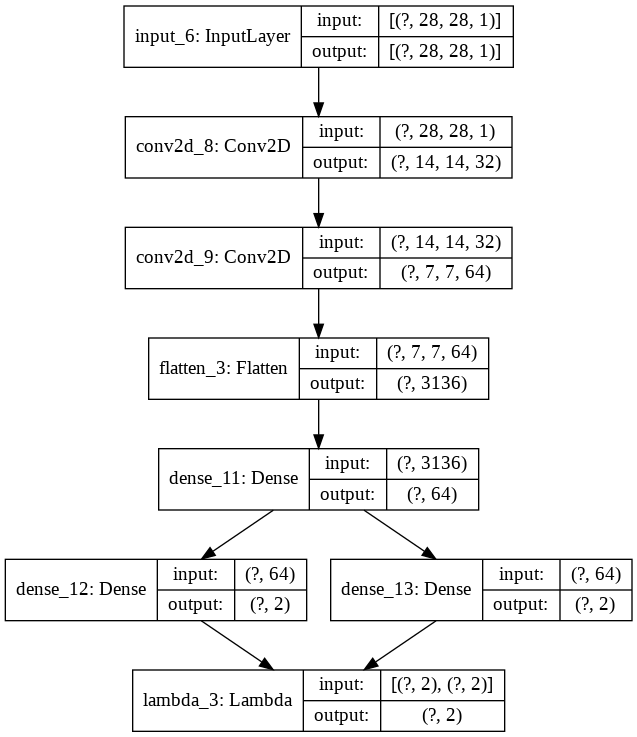

In [37]:
# endoer term

encoder=Model(input_img,[z_mean,z_log_var,z] ) # 이렇게 3개를 output으로 꺼낼수 있음. 그러면 encoder를 통과할 시, output이 3개로 나옴. 물론 그림에서는 의미없음.
encoder.summary()
plot_model(encoder,show_shapes=True)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_14 (Dense)             (None, 3136)              9408      
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

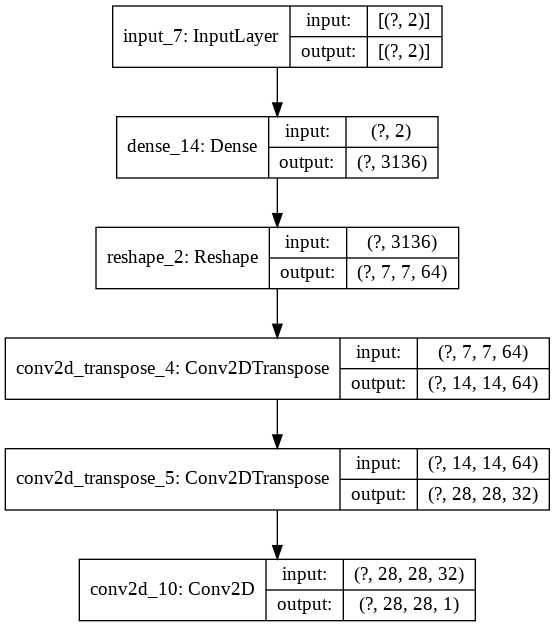

In [38]:
# decoder term

latent_input=layers.Input(shape=(latent_dim,))
x=layers.Dense(np.prod(shape[1:]), activation='relu')(latent_input) # np.prod 곱하기
x=layers.Reshape(shape[1:])(x) # reshape을 진행.
x=layers.Conv2DTranspose(64,3,padding='same',strides=2,activation='relu')(x)
x=layers.Conv2DTranspose(32,3,padding='same',strides=2,activation='relu')(x)
output=layers.Conv2D(1,3, padding='same',activation='sigmoid')(x)
decoder=Model(latent_input,output)
decoder.summary()
plot_model(decoder, show_shapes=True)

In [39]:
f_output=decoder(encoder(input_img)[2])  # 나는 z에 해당하는 부분만 볼것이기 때문에 이렇게 씀.
vae=Model(input_img, f_output)
vae.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_7 (Model)              [(None, 2), (None, 2), (N 219844    
_________________________________________________________________
model_8 (Model)              (None, 28, 28, 1)         65089     
Total params: 284,933
Trainable params: 284,933
Non-trainable params: 0
_________________________________________________________________


In [40]:
# loss function이 built-in이 아니기 떄문에, 정의해야함.
# customized loss를 함.
input_img1=k.flatten(input_img) #none 으로 나오지만, 이게 1차원 tensor인거임. 1차원 칸에 해당하는 값이 (28x28의 길이만큼) 들어가있음.
f_output1=k.flatten(f_output)
print(input_img1, f_output1)

reconstruction_loss=tensorflow.keras.losses.mse(input_img1, f_output1) # 모든 pixel에 대해 mse를 구함.
reconstruction_loss*=input_img.shape[1]*input_img.shape[1] # 28*28를 곱하는 이유는, 28*28에 대한 평균을 구했기 때문에 그럼. 우리는 loss(summation으로 이루어짐.)를 구하기 위해선, 28*28을 곱해줌.

inference_loss=1 + z_log_var-k.square(z_mean)-k.exp(z_log_var) # 추론손실 이해 
inference_loss=k.sum(inference_loss, axis=-1)*-0.5

vae_loss=k.mean(reconstruction_loss+inference_loss)

vae.add_loss(vae_loss)
# loss로 정의하려면 add_loss를 정의하면 끝.

vae.compile(optimizer='rmsprop')

Tensor("Reshape_5:0", shape=(None,), dtype=float32) Tensor("Reshape_6:0", shape=(None,), dtype=float32)


In [41]:
from tensorflow.keras.datasets import mnist

(x_train,_),(x_test,y_test)=mnist.load_data()
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


vae.fit(x_train, epochs=10, shuffle=True, batch_size=batch_size, validation_data=(x_test,None)) # none 을 쓰거나, 1개만 입력해도 됨.

Epoch 1/10
3750/3750 [==============================] - 32s 8ms/step - loss: 43.2073 - val_loss: 40.1365
Epoch 2/10
3750/3750 [==============================] - 31s 8ms/step - loss: 39.2319 - val_loss: 38.8728
Epoch 3/10
3750/3750 [==============================] - 31s 8ms/step - loss: 38.2585 - val_loss: 38.0020
Epoch 4/10
3750/3750 [==============================] - 31s 8ms/step - loss: 37.7436 - val_loss: 37.8781
Epoch 5/10
3750/3750 [==============================] - 30s 8ms/step - loss: 37.4657 - val_loss: 37.4566
Epoch 6/10
3750/3750 [==============================] - 31s 8ms/step - loss: 37.2819 - val_loss: 37.1785
Epoch 7/10
3750/3750 [==============================] - 31s 8ms/step - loss: 37.1313 - val_loss: 37.0904
Epoch 8/10
3750/3750 [==============================] - 31s 8ms/step - loss: 37.0348 - val_loss: 37.4447
Epoch 9/10
3750/3750 [==============================] - 31s 8ms/step - loss: 36.9921 - val_loss: 37.4408
Epoch 10/10
3750/3750 [==============================] 

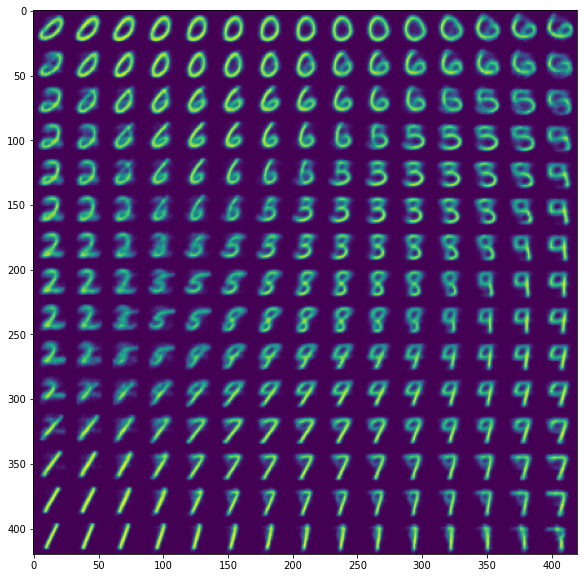

In [42]:
# 이 아래는 재생시켜서 확인하는 코드.
# decoder 에 z sample 그대로 넣으면됨.
# 이미지가 어떻게 변해가는지를 확인할 수 있음.


import matplotlib.pyplot as plt
from scipy.stats import norm
n=15
image_size=28
figure=np.zeros((image_size*n,image_size*n)) # 15x15개의 숫자를 출력할 예정. -> 15*28 = 420 이며, output그림의 한 변의길이.
z_x=norm.ppf(np.linspace(0.05,0.95,n)) # standard normal에서 그냥꺼냄. / z는 그 의미답게 히든노드의 의미임.
z_y=norm.ppf(np.linspace(0.05,0.95,n)) 

for i,y in enumerate(z_y): # y축의 분위수값
    for j, x in enumerate(z_x): # x축의 분위수값
        z_sample=np.array([[x,y]]) # 결과 class에 대한 분포에 대해, x축: 하위 5%, y축: 하위 5%
        z_sample=np.tile(z_sample, batch_size).reshape(batch_size,latent_dim) 
        # np.tile(A,(2,3,4)) 는 , A를 (2,3,4) 차원만큼 복사해라 라는 의미. 즉, A=(a1,a2,a3)라 할 때, output= (2a1,3a2,4a3) 의 차원을 지님. 
        # 여기서는, np.tile(z_sample,16) 이므로, z_sample을 -1축으로 16개 복사함. 이를 reshape하므로, z_sample의 최종 shape은 당연히 (16,2)

        x_decoded=decoder.predict(z_sample) # 16개의 예제에 대해, decoder predict를 진행. 이때 encoder는 사용을 안함.
        digit=x_decoded[0].reshape(image_size, image_size) # 1개의 sample에 대해서, 진행.
        figure[i*image_size:(i+1)*image_size, j*image_size:(j+1)*image_size]=digit # 하나씩 하나씩 할당. 왼쪽 위 대각선부터 할당. 

plt.figure(figsize=(10,10)) # 즉 , 이게 숫자분포. (decoder 분포)
plt.imshow(figure)
plt.show()




In [0]:
img_shape=(28,28,1)
batch_size=16
latent_dim=2  # normal가정이 2변량정규분포.

input_img=layers.Input(shape=img_shape)
x=layers.Conv2D(32,3,padding='same', strides=2, activation='relu')(input_img)
x=layers.Conv2D(64,3, padding='same', strides=2, activation='relu')(x)
shape=k.int_shape(x)
x=layers.Flatten()(x)
x=layers.Dense(128, activation='relu')(x)
z_mean=layers.Dense(latent_dim)(x)
z_log_var=layers.Dense(latent_dim)(x) # log variance 임. loss function에서 log를 썼을때 수렴이 더빠름.
# log를 안써도 됨.

In [0]:
# inference loss를 정의하려고 그럼.

def sampling(args):
    z_mean,z_log_var=args
    batch=k.shape(z_mean)[0] # z_mean은 (none,2), none을 제외한다면 2차원 열 벡터임.  k.shape 하면, tensor그릇을 생성. k.int_shape하면 숫자를 생성.
    dim=k.int_shape(z_mean)[1]
    epsilon=k.random_normal(shape=(batch,dim)) # normal(0,1) // z의 노드를 iid로 가정하기 때문에 이게 가능. 개별로봄. 이걸 가정하자는게 결론이었음.
    return z_mean+k.exp(0.5*z_log_var)*epsilon  # 공식 정의. # 0.5*z_log_var = log (sigma) 임.


z=layers.Lambda(sampling,output_shape=(latent_dim,))([z_mean,z_log_var])  # 함수에 해당하는 인자를 인자를 input으로 받음. 그리고 그 input은 layer였음. 이렇게 되면, z라는 노드는 mu1, sigma1 정규에서 만들어진 값. 
# layer 로 정의해주려면 lambda함수를 사용하면 됨.
# built - in 이 아니기 때문에, 이렇게 만들어놓음.
# output_shape=(latent_dim,) 안써도 됨.


# *************** 아래는 매우 중요 ****************
# 정리하자면,
# encoder는 최종적인 잠재변수 z가 N(0,1) 이 되도록 parameter(beta)가 학습됨. 즉, mu=0,sigma=1 의 노드를 갖도록 앞의 encoder beta들이 학습됨.
# 그리고 이와 동시에, decoder쪽에서도 loss를 줄이기 위해 대응되면서 parameter가 학습됨. (output이 잘 나오도록.)
# 이게, 어떤 데이터가 들어오더라도 이렇게 이루어지기 때문에, 모두가 동시에 살아 움직이는거임.

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 14, 14, 32)   320         input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 7, 7, 64)     18496       conv2d_11[0][0]                  
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 3136)         0           conv2d_12[0][0]                  
___________________________________________________________________________________________

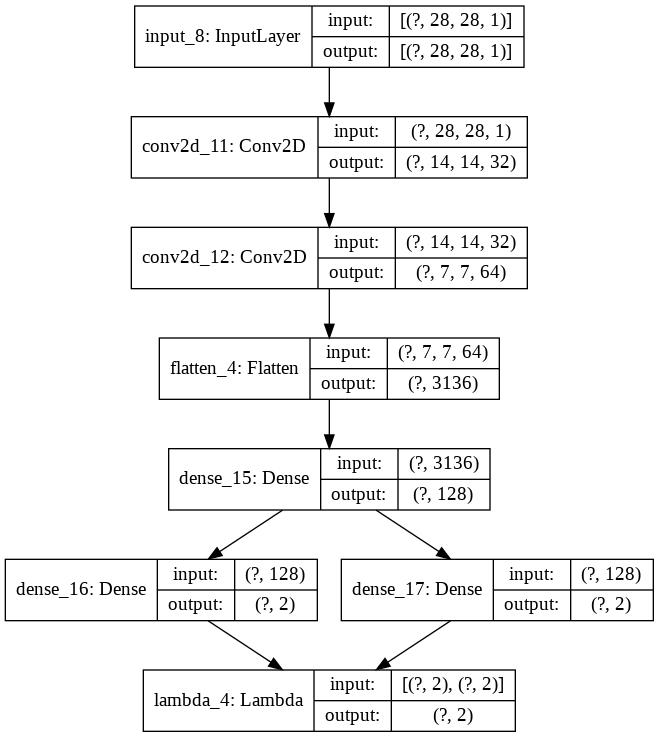

In [45]:
# endoer term

encoder=Model(input_img,[z_mean,z_log_var,z] ) # 이렇게 3개를 output으로 꺼낼수 있음. 그러면 encoder를 통과할 시, output이 3개로 나옴. 물론 그림에서는 의미없음.
encoder.summary()
plot_model(encoder,show_shapes=True)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_18 (Dense)             (None, 3136)              9408      
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
______________________________________________________

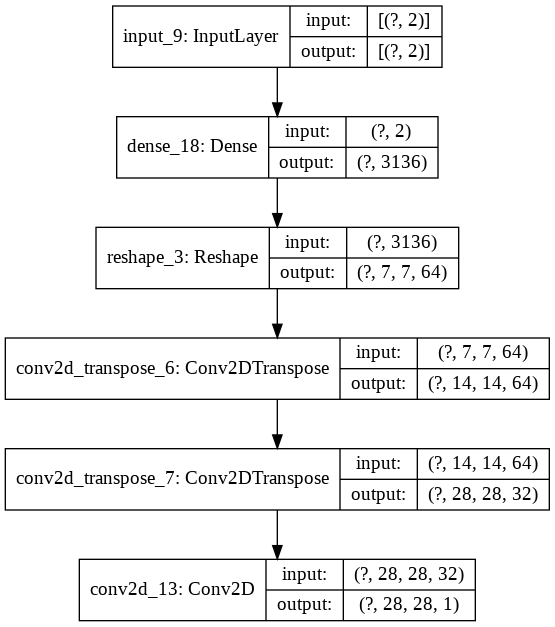

In [46]:
# decoder term

latent_input=layers.Input(shape=(latent_dim,))
x=layers.Dense(np.prod(shape[1:]), activation='relu')(latent_input) # np.prod 곱하기
x=layers.Reshape(shape[1:])(x) # reshape을 진행.
x=layers.Conv2DTranspose(64,3,padding='same',strides=2,activation='relu')(x)
x=layers.Conv2DTranspose(32,3,padding='same',strides=2,activation='relu')(x)
output=layers.Conv2D(1,3, padding='same',activation='sigmoid')(x)
decoder=Model(latent_input,output)
decoder.summary()
plot_model(decoder, show_shapes=True)

In [47]:
f_output=decoder(encoder(input_img)[2])  # 나는 z에 해당하는 부분만 볼것이기 때문에 이렇게 씀.
vae=Model(input_img, f_output)
vae.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_10 (Model)             [(None, 2), (None, 2), (N 420868    
_________________________________________________________________
model_11 (Model)             (None, 28, 28, 1)         65089     
Total params: 485,957
Trainable params: 485,957
Non-trainable params: 0
_________________________________________________________________


In [48]:
# loss function이 built-in이 아니기 떄문에, 정의해야함.
# customized loss를 함.
input_img1=k.flatten(input_img) #none 으로 나오지만, 이게 1차원 tensor인거임. 1차원 칸에 해당하는 값이 (28x28의 길이만큼) 들어가있음.
f_output1=k.flatten(f_output)
print(input_img1, f_output1)

reconstruction_loss=tensorflow.keras.losses.mse(input_img1, f_output1) # 모든 pixel에 대해 mse를 구함.
reconstruction_loss*=input_img.shape[1]*input_img.shape[1] # 28*28를 곱하는 이유는, 28*28에 대한 평균을 구했기 때문에 그럼. 우리는 loss(summation으로 이루어짐.)를 구하기 위해선, 28*28을 곱해줌.

inference_loss=1 + z_log_var-k.square(z_mean)-k.exp(z_log_var) # 추론손실 이해 
inference_loss=k.sum(inference_loss, axis=-1)*-0.5

vae_loss=k.mean(reconstruction_loss+inference_loss)

vae.add_loss(vae_loss)
# loss로 정의하려면 add_loss를 정의하면 끝.

vae.compile(optimizer='rmsprop')

Tensor("Reshape_7:0", shape=(None,), dtype=float32) Tensor("Reshape_8:0", shape=(None,), dtype=float32)


In [49]:
from tensorflow.keras.datasets import mnist

(x_train,_),(x_test,y_test)=mnist.load_data()
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


vae.fit(x_train, epochs=10, shuffle=True, batch_size=batch_size, validation_data=(x_test,None)) # none 을 쓰거나, 1개만 입력해도 됨.

Epoch 1/10
3750/3750 [==============================] - 43s 11ms/step - loss: 42.7109 - val_loss: 39.5550
Epoch 2/10
3750/3750 [==============================] - 43s 11ms/step - loss: 38.9526 - val_loss: 38.2380
Epoch 3/10
3750/3750 [==============================] - 43s 11ms/step - loss: 38.0441 - val_loss: 38.0387
Epoch 4/10
3750/3750 [==============================] - 42s 11ms/step - loss: 37.5440 - val_loss: 37.5222
Epoch 5/10
3750/3750 [==============================] - 42s 11ms/step - loss: 37.2428 - val_loss: 37.1992
Epoch 6/10
3750/3750 [==============================] - 42s 11ms/step - loss: 37.0493 - val_loss: 37.1957
Epoch 7/10
3750/3750 [==============================] - 41s 11ms/step - loss: 36.8981 - val_loss: 36.9030
Epoch 8/10
3750/3750 [==============================] - 41s 11ms/step - loss: 36.7646 - val_loss: 37.2811
Epoch 9/10
3750/3750 [==============================] - 41s 11ms/step - loss: 36.6923 - val_loss: 36.7309
Epoch 10/10
3750/3750 [=======================

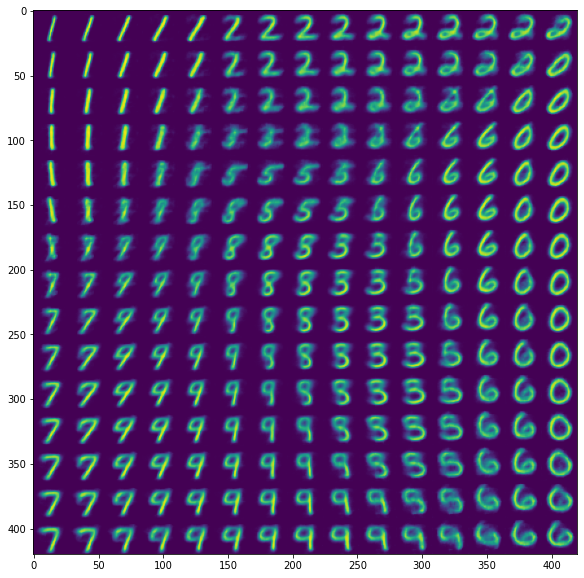

In [50]:
# 이 아래는 재생시켜서 확인하는 코드.
# decoder 에 z sample 그대로 넣으면됨.
# 이미지가 어떻게 변해가는지를 확인할 수 있음.


import matplotlib.pyplot as plt
from scipy.stats import norm
n=15
image_size=28
figure=np.zeros((image_size*n,image_size*n)) # 15x15개의 숫자를 출력할 예정. -> 15*28 = 420 이며, output그림의 한 변의길이.
z_x=norm.ppf(np.linspace(0.05,0.95,n)) # standard normal에서 그냥꺼냄. / z는 그 의미답게 히든노드의 의미임.
z_y=norm.ppf(np.linspace(0.05,0.95,n)) 

for i,y in enumerate(z_y): # y축의 분위수값
    for j, x in enumerate(z_x): # x축의 분위수값
        z_sample=np.array([[x,y]]) # 결과 class에 대한 분포에 대해, x축: 하위 5%, y축: 하위 5%
        z_sample=np.tile(z_sample, batch_size).reshape(batch_size,latent_dim) 
        # np.tile(A,(2,3,4)) 는 , A를 (2,3,4) 차원만큼 복사해라 라는 의미. 즉, A=(a1,a2,a3)라 할 때, output= (2a1,3a2,4a3) 의 차원을 지님. 
        # 여기서는, np.tile(z_sample,16) 이므로, z_sample을 -1축으로 16개 복사함. 이를 reshape하므로, z_sample의 최종 shape은 당연히 (16,2)

        x_decoded=decoder.predict(z_sample) # 16개의 예제에 대해, decoder predict를 진행. 이때 encoder는 사용을 안함.
        digit=x_decoded[0].reshape(image_size, image_size) # 1개의 sample에 대해서, 진행.
        figure[i*image_size:(i+1)*image_size, j*image_size:(j+1)*image_size]=digit # 하나씩 하나씩 할당. 왼쪽 위 대각선부터 할당. 

plt.figure(figsize=(10,10)) # 즉 , 이게 숫자분포. (decoder 분포)
plt.imshow(figure)
plt.show()




In [0]:
# 3. 1+2를 동시에 적용하여 변화를 논의할 것.


In [0]:
img_shape=(28,28,1)
batch_size=16
latent_dim=5  # normal가정이 2변량정규분포.

input_img=layers.Input(shape=img_shape)
x=layers.Conv2D(32,3,padding='same', strides=2, activation='relu')(input_img)
x=layers.Conv2D(64,3, padding='same', strides=2, activation='relu')(x)
shape=k.int_shape(x)
x=layers.Flatten()(x)
x=layers.Dense(128, activation='relu')(x)
z_mean=layers.Dense(latent_dim)(x)
z_log_var=layers.Dense(latent_dim)(x) # log variance 임. loss function에서 log를 썼을때 수렴이 더빠름.
# log를 안써도 됨.

In [0]:
# inference loss를 정의하려고 그럼.

def sampling(args):
    z_mean,z_log_var=args
    batch=k.shape(z_mean)[0] # z_mean은 (none,2), none을 제외한다면 2차원 열 벡터임.  k.shape 하면, tensor그릇을 생성. k.int_shape하면 숫자를 생성.
    dim=k.int_shape(z_mean)[1]
    epsilon=k.random_normal(shape=(batch,dim)) # normal(0,1) // z의 노드를 iid로 가정하기 때문에 이게 가능. 개별로봄. 이걸 가정하자는게 결론이었음.
    return z_mean+k.exp(0.5*z_log_var)*epsilon  # 공식 정의. # 0.5*z_log_var = log (sigma) 임.


z=layers.Lambda(sampling,output_shape=(latent_dim,))([z_mean,z_log_var])  # 함수에 해당하는 인자를 인자를 input으로 받음. 그리고 그 input은 layer였음. 이렇게 되면, z라는 노드는 mu1, sigma1 정규에서 만들어진 값. 
# layer 로 정의해주려면 lambda함수를 사용하면 됨.
# built - in 이 아니기 때문에, 이렇게 만들어놓음.
# output_shape=(latent_dim,) 안써도 됨.


# *************** 아래는 매우 중요 ****************
# 정리하자면,
# encoder는 최종적인 잠재변수 z가 N(0,1) 이 되도록 parameter(beta)가 학습됨. 즉, mu=0,sigma=1 의 노드를 갖도록 앞의 encoder beta들이 학습됨.
# 그리고 이와 동시에, decoder쪽에서도 loss를 줄이기 위해 대응되면서 parameter가 학습됨. (output이 잘 나오도록.)
# 이게, 어떤 데이터가 들어오더라도 이렇게 이루어지기 때문에, 모두가 동시에 살아 움직이는거임.

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 14, 14, 32)   320         input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 7, 7, 64)     18496       conv2d_19[0][0]                  
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 3136)         0           conv2d_20[0][0]                  
___________________________________________________________________________________________

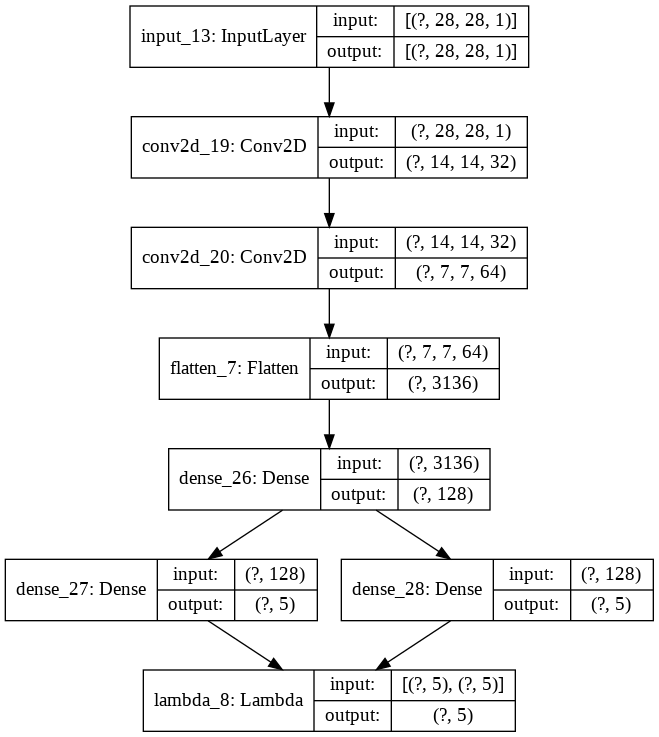

In [65]:
# endoer term

encoder=Model(input_img,[z_mean,z_log_var,z] ) # 이렇게 3개를 output으로 꺼낼수 있음. 그러면 encoder를 통과할 시, output이 3개로 나옴. 물론 그림에서는 의미없음.
encoder.summary()
plot_model(encoder,show_shapes=True)

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 5)]               0         
_________________________________________________________________
dense_29 (Dense)             (None, 3136)              18816     
_________________________________________________________________
reshape_5 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 1)         289       
Total params: 74,497
Trainable params: 74,497
Non-trainable params: 0
______________________________________________________

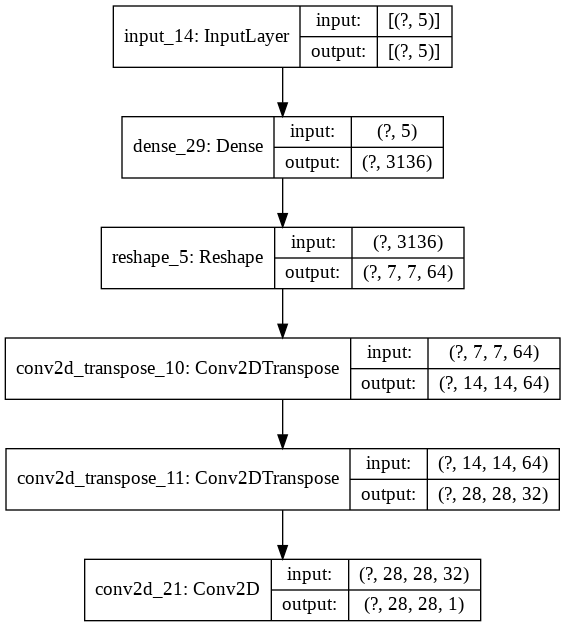

In [66]:
# decoder term

latent_input=layers.Input(shape=(latent_dim,))
x=layers.Dense(np.prod(shape[1:]), activation='relu')(latent_input) # np.prod 곱하기
x=layers.Reshape(shape[1:])(x) # reshape을 진행.
x=layers.Conv2DTranspose(64,3,padding='same',strides=2,activation='relu')(x)
x=layers.Conv2DTranspose(32,3,padding='same',strides=2,activation='relu')(x)
output=layers.Conv2D(1,3, padding='same',activation='sigmoid')(x)
decoder=Model(latent_input,output)
decoder.summary()
plot_model(decoder, show_shapes=True)

In [67]:
f_output=decoder(encoder(input_img)[2])  # 나는 z에 해당하는 부분만 볼것이기 때문에 이렇게 씀.
vae=Model(input_img, f_output)
vae.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_17 (Model)             [(None, 5), (None, 5), (N 421642    
_________________________________________________________________
model_18 (Model)             (None, 28, 28, 1)         74497     
Total params: 496,139
Trainable params: 496,139
Non-trainable params: 0
_________________________________________________________________


In [68]:
# loss function이 built-in이 아니기 떄문에, 정의해야함.
# customized loss를 함.
input_img1=k.flatten(input_img) #none 으로 나오지만, 이게 1차원 tensor인거임. 1차원 칸에 해당하는 값이 (28x28의 길이만큼) 들어가있음.
f_output1=k.flatten(f_output)
print(input_img1, f_output1)

reconstruction_loss=tensorflow.keras.losses.mse(input_img1, f_output1) # 모든 pixel에 대해 mse를 구함.
reconstruction_loss*=input_img.shape[1]*input_img.shape[1] # 28*28를 곱하는 이유는, 28*28에 대한 평균을 구했기 때문에 그럼. 우리는 loss(summation으로 이루어짐.)를 구하기 위해선, 28*28을 곱해줌.

inference_loss=1 + z_log_var-k.square(z_mean)-k.exp(z_log_var) # 추론손실 이해 
inference_loss=k.sum(inference_loss, axis=-1)*-0.5

vae_loss=k.mean(reconstruction_loss+inference_loss)

vae.add_loss(vae_loss)
# loss로 정의하려면 add_loss를 정의하면 끝.

vae.compile(optimizer='rmsprop')

Tensor("Reshape_11:0", shape=(None,), dtype=float32) Tensor("Reshape_12:0", shape=(None,), dtype=float32)


In [69]:
from tensorflow.keras.datasets import mnist

(x_train,_),(x_test,y_test)=mnist.load_data()
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


vae.fit(x_train, epochs=10, shuffle=True, batch_size=batch_size, validation_data=(x_test,None)) # none 을 쓰거나, 1개만 입력해도 됨.

Epoch 1/10
3750/3750 [==============================] - 43s 11ms/step - loss: 36.1692 - val_loss: 32.5989
Epoch 2/10
3750/3750 [==============================] - 43s 11ms/step - loss: 32.1219 - val_loss: 31.2302
Epoch 3/10
3750/3750 [==============================] - 42s 11ms/step - loss: 31.2361 - val_loss: 30.9138
Epoch 4/10
3750/3750 [==============================] - 41s 11ms/step - loss: 30.7375 - val_loss: 30.6109
Epoch 5/10
3750/3750 [==============================] - 41s 11ms/step - loss: 30.4245 - val_loss: 30.2496
Epoch 6/10
3750/3750 [==============================] - 41s 11ms/step - loss: 30.2111 - val_loss: 30.2288
Epoch 7/10
3750/3750 [==============================] - 40s 11ms/step - loss: 30.0394 - val_loss: 29.8975
Epoch 8/10
3750/3750 [==============================] - 40s 11ms/step - loss: 29.9144 - val_loss: 29.8167
Epoch 9/10
3750/3750 [==============================] - 41s 11ms/step - loss: 29.7972 - val_loss: 29.7705
Epoch 10/10
3750/3750 [=======================

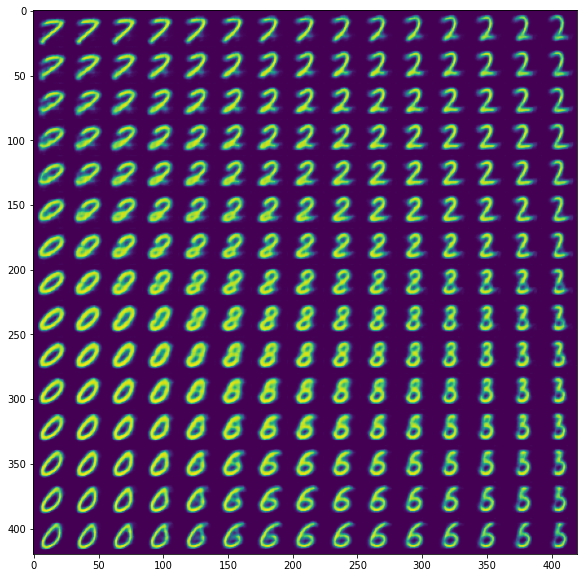

In [88]:
# 이 아래는 재생시켜서 확인하는 코드.
# decoder 에 z sample 그대로 넣으면됨.
# 이미지가 어떻게 변해가는지를 확인할 수 있음.


import matplotlib.pyplot as plt
from scipy.stats import norm
n=15
image_size=28
figure=np.zeros((image_size*n,image_size*n)) # 15x15개의 숫자를 출력할 예정. -> 15*28 = 420 이며, output그림의 한 변의길이.
z_x=norm.ppf(np.linspace(0.05,0.95,n)) # standard normal에서 그냥꺼냄. / z는 그 의미답게 히든노드의 의미임.
z_y=norm.ppf(np.linspace(0.05,0.95,n)) 

for i,y in enumerate(z_y): # y축의 분위수값
    for j, x in enumerate(z_x): # x축의 분위수값
        z_sample=np.array([[x,y,0,0.5,-0.5]]) # 결과 class에 대한 분포에 대해, x축: 하위 5%, y축: 하위 5%
        z_sample=np.tile(z_sample, batch_size).reshape(batch_size,latent_dim) 
        # np.tile(A,(2,3,4)) 는 , A를 (2,3,4) 차원만큼 복사해라 라는 의미. 즉, A=(a1,a2,a3)라 할 때, output= (2a1,3a2,4a3) 의 차원을 지님. 
        # 여기서는, np.tile(z_sample,16) 이므로, z_sample을 -1축으로 16개 복사함. 이를 reshape하므로, z_sample의 최종 shape은 당연히 (16,2)

        x_decoded=decoder.predict(z_sample) # 16개의 예제에 대해, decoder predict를 진행. 이때 encoder는 사용을 안함.
        digit=x_decoded[0].reshape(image_size, image_size) # 1개의 sample에 대해서, 진행.
        figure[i*image_size:(i+1)*image_size, j*image_size:(j+1)*image_size]=digit # 하나씩 하나씩 할당. 왼쪽 위 대각선부터 할당. 

plt.figure(figsize=(10,10)) # 즉 , 이게 숫자분포. (decoder 분포)
plt.imshow(figure)
plt.show()




In [0]:
# 4. 프로그램 11.3의 tile의 의미를 설명하고 그림 그리는 프로그램을 해설할 것.